# Major Goal

This project is built based on the other California Housing Price Prediction Project. The dataset used is the same. In the dataset, the variable `median_house_value` and `median_house_age` have a upper bound during the data collection period. Even though they are numerical attributes, the largest number actually means that any number greater than or equal to that number. Our previous model is built without dropping these large number. Due to the existence of large number of these number, our model selection and training might be heavily impacted. Therefore, we are interested in what will the finalized model be like after removing the upper bound, and how the prediction would be improved.

## Obtain the Data

In [73]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
fetch_housing_data()

## Import Libraries

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab


## Load Data to Data Frame

In [75]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# load the data to housing data frame
housing = load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Dropping the Data at the Caped Amount

We will ignore the steps of exploring the dataset as it has been done thoroughly in the previous project

In [76]:
# original dataset shape
original_shape = housing.shape

In [77]:
# dropping the upper bound values for housing_median_age
housing = housing[housing.housing_median_age < 50] 

# dropping the upper bound values for median_house_value
housing = housing[housing.median_house_value < 500000]

In [78]:
print(f'there are {original_shape[0] - housing.shape[0]} rows are dropped')
print(f'there are {housing.shape[0]} rows in the dataset now')

there are 2252 rows are dropped
there are 18388 rows in the dataset now


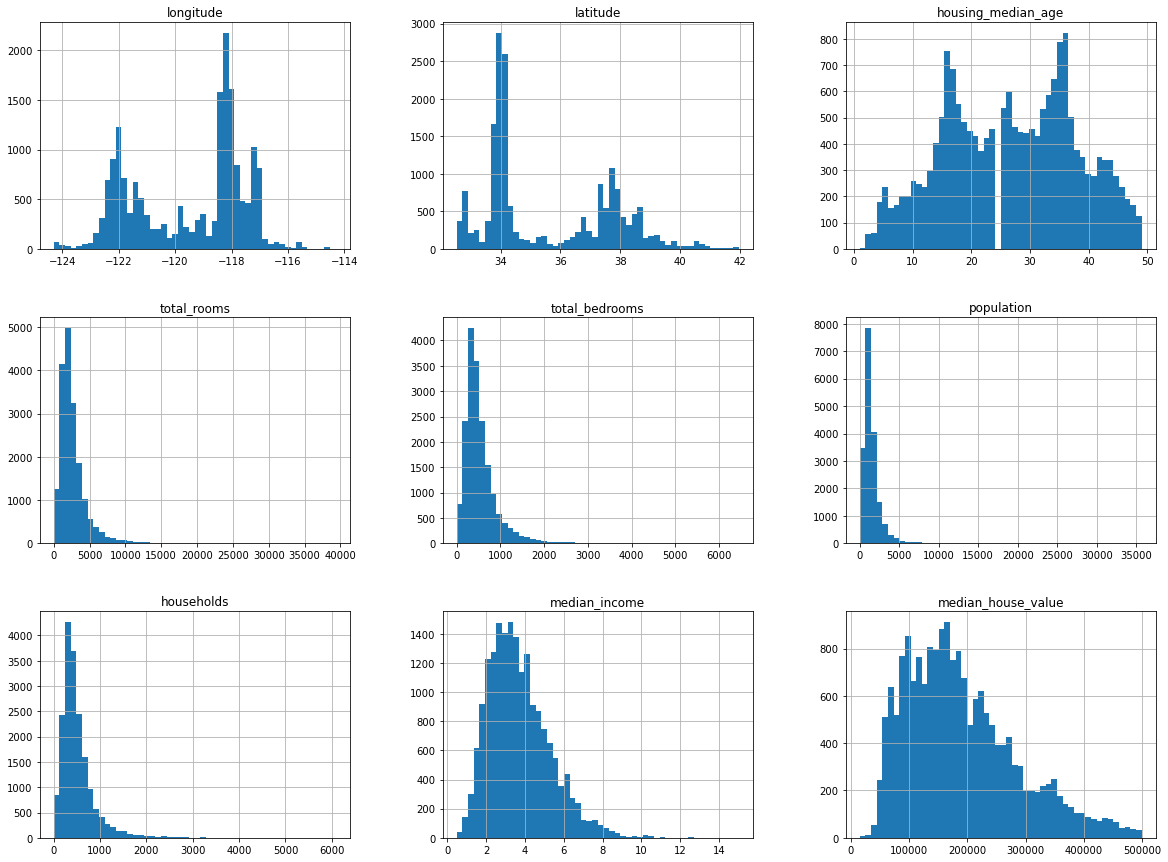

In [79]:
# Visualize the distribution of each variable again
%matplotlib inline

housing.hist(bins=50, figsize = (20, 15))
plt.show()

Obviously, the high vertical bars at the right most of the `median_house_value` and `housing_median_value` are now removed.

There are no notable changes to other variables after we have droped these rows. Their shape of distibution is preserved.

One thing to note is that the small bar at 15.001 in median_income distribution seems to disappear. That bar is also the upper bound set for this colume. Let's confirm if every value has been removed.

In [80]:
housing[housing.median_income > 15]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1566,-121.96,37.74,2.0,200.0,20.0,25.0,9.0,15.0001,350000.0,<1H OCEAN
18504,-121.96,37.13,26.0,50.0,5.0,17.0,4.0,15.0001,400000.0,<1H OCEAN


There are still 2 entries are left in our dataset. This would be a implication of the following two conclusions.
1. The high the median_income has a association with high median_house_value. This matches with what we have learnt from the previous project
2. There are other attributes that have huge impact on the house price as indicated with these two remaining entries. Even though the median_income is at the highest, the median_house_value is not close to the highest at all. Of course, they might just be outliners; we'll take a record for now.

## Create a Test Set

<AxesSubplot:>

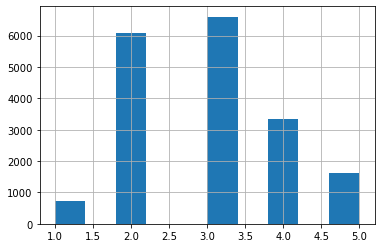

In [81]:
# median_income has the biggest impact on median_house_value, we use stratification on median_income for sampling purpose
housing['income_category'] = pd.cut(housing['median_income'], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5]) 
# group the median_income into the designed categories
housing["income_category"].hist()

In [82]:
# We now separate the train, test set based on the median_income categories
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing.income_category):
    train_set = housing.iloc[train_index]
    test_set = housing.iloc[test_index]

train_set.shape, test_set.shape
    

((14710, 11), (3678, 11))

In [83]:
# drop the income category to bring the data frame to its original state

for set in (train_set, test_set):
    set.drop('income_category', axis = 1, inplace = True)

C:\Users\ZHou\Anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [84]:
# check to make sure the colume is correctly removed
train_set = train_set.reset_index().drop('index', axis = 1)
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-118.42,34.15,27.0,2795.0,602.0,1073.0,535.0,5.1496,365000.0,<1H OCEAN
1,-122.78,38.41,43.0,1351.0,277.0,1011.0,297.0,2.5917,144000.0,<1H OCEAN
2,-118.45,34.00,43.0,1606.0,408.0,862.0,354.0,3.9620,345800.0,<1H OCEAN
3,-120.81,39.02,30.0,806.0,189.0,326.0,146.0,2.8155,101000.0,INLAND
4,-122.02,37.35,26.0,2785.0,418.0,1221.0,422.0,8.1078,365700.0,<1H OCEAN


In [85]:
# create a copy of the train set, so that we do not manipulate the train set by mistake
housing = train_set.copy()
housing = housing.reset_index().drop('index', axis = 1)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-118.42,34.15,27.0,2795.0,602.0,1073.0,535.0,5.1496,365000.0,<1H OCEAN
1,-122.78,38.41,43.0,1351.0,277.0,1011.0,297.0,2.5917,144000.0,<1H OCEAN
2,-118.45,34.00,43.0,1606.0,408.0,862.0,354.0,3.9620,345800.0,<1H OCEAN
3,-120.81,39.02,30.0,806.0,189.0,326.0,146.0,2.8155,101000.0,INLAND
4,-122.02,37.35,26.0,2785.0,418.0,1221.0,422.0,8.1078,365700.0,<1H OCEAN


The following exploration should not exhibit new patterns. We'll quickly go over the following steps. If there are any new patterns revealed, we will mark it out. 

### Visualizing the Geographical Data

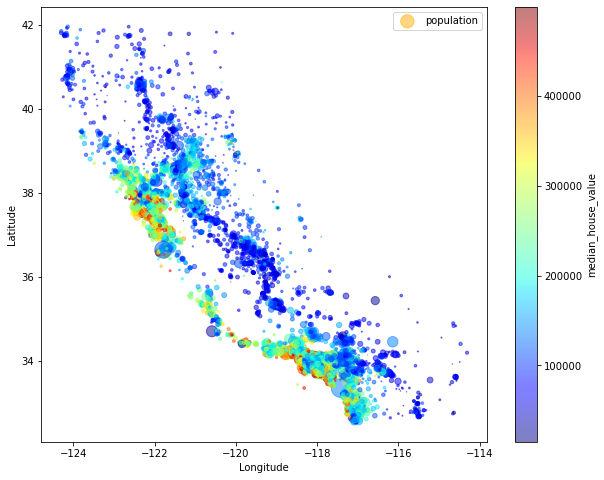

In [86]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.scatter(housing.longitude, housing.latitude, alpha = 0.5,
           s = housing['population']/100, c = housing.median_house_value,
           cmap = plt.get_cmap('jet'))
cbar = plt.colorbar()
cbar.set_label("median_house_value")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(labels = ['population', 'median_house_value'])

<AxesSubplot:>

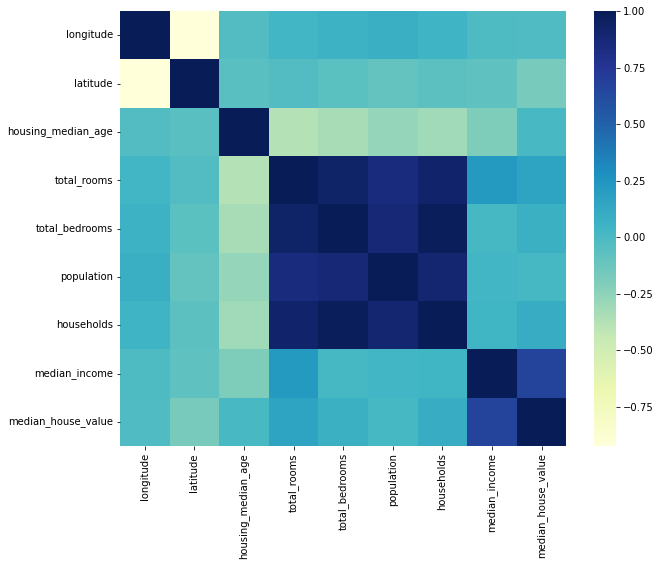

In [87]:
### Variable Correlation

fig = plt.figure(figsize=(10, 8))
sns.heatmap(housing.corr(), cmap='YlGnBu')


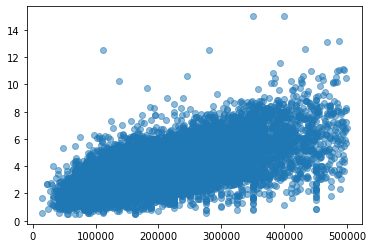

In [88]:
plt.scatter(housing.median_house_value, housing.median_income, alpha = 0.5)

Without the values capped at 500000, the graph demonstrates a clear positive, linear relationship between `median_income` and `median_house_value`

### Attribute Combinations

In [89]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()
print(corr_matrix['median_house_value'].sort_values(ascending = False))

median_house_value          1.000000
median_income               0.664015
total_rooms                 0.152194
rooms_per_household         0.111367
households                  0.100059
total_bedrooms              0.078532
population                  0.021837
housing_median_age          0.013814
population_per_household   -0.018655
longitude                  -0.020941
latitude                   -0.172714
bedrooms_per_room          -0.232943
Name: median_house_value, dtype: float64


Interestingly, after dropping those values, the correlation of rooms_per_household with median_house_value is weeker than that of total_rooms with median_house_value. However, the change is very small; it wouldn't really change result drastically. Noteably, median_income is still the dominant factor that influences the median_house_value. 

## Prepare the Data

In [90]:
# Separare the predictors and labels

housing = train_set.drop('median_house_value', axis = 1)
housing_labels = train_set['median_house_value'].copy()
                           

### Data Cleaning

In [91]:
from sklearn.base import BaseEstimator, TransformerMixin

room_ind = housing.columns.get_loc("total_rooms")
household_ind = housing.columns.get_loc("households")
bedroom_ind = housing.columns.get_loc("total_bedrooms")
population_ind = housing.columns.get_loc("population")
        

class NewCombinedAttribute(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True, 
                add_rooms_per_household = True,
                 add_population_per_household = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.add_population_per_household = add_population_per_household
        self.add_rooms_per_household = add_rooms_per_household
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        add_attr = [self.add_bedrooms_per_room, self.add_rooms_per_household, self.add_population_per_household]
        rooms_per_household = X[:, room_ind] / X[:, household_ind]
        population_per_household = X[:, population_ind] / X[: ,household_ind]
        bedrooms_per_room = X[:, bedroom_ind] / X[:, room_ind]
        attrs = [bedrooms_per_room, rooms_per_household, population_per_household]
        for ifadd, pos in zip(add_attr, range(len(attrs))):
            if not ifadd:
                attrs.remove(attrs[pos])
            else:
                attrs[pos] = attrs[pos].reshape((len(X), 1))
        attrs.insert(0, X)
        attrs = np.concatenate(attrs, axis = 1)
        return attrs




### Feature Scaling

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('new_attr', NewCombinedAttribute()),
    ('std_scaler', StandardScaler()),
]) # for numerical attributes

num_attribs = list(num_housing)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("encoder", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

## Model Selection and Training

### Linear Regression

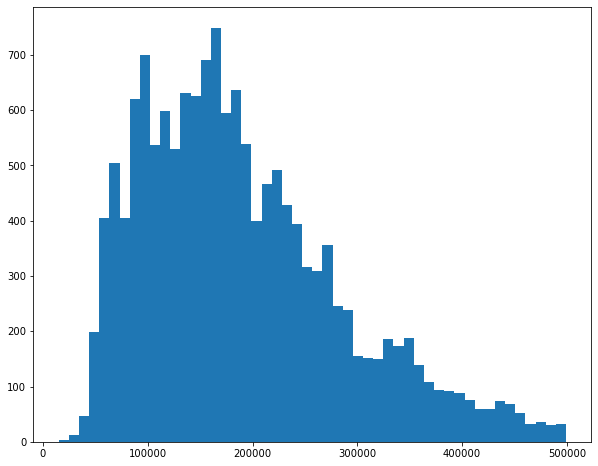

In [94]:
fig = plt.figure(figsize=(10, 8))
plt.hist(housing_labels, bins=50)
plt.show()

C:\Users\ZHou\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


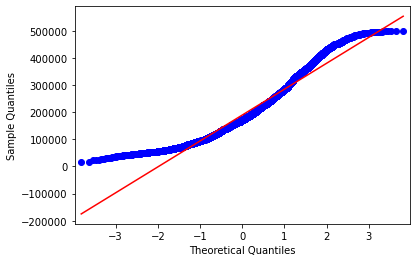

In [95]:
sm.qqplot(housing_labels, line = 's')
pylab.show()

C:\Users\ZHou\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


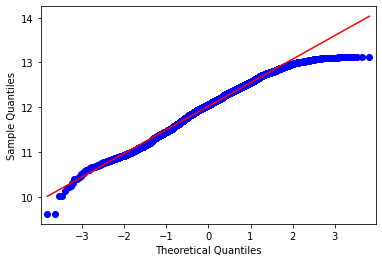

In [96]:
sm.qqplot(np.log(housing_labels), line = 's')
pylab.show()

In [113]:
from sklearn.linear_model import LinearRegression

log_housing_labels = np.log(housing_labels)
lm = LinearRegression()

lm.fit(housing_prepared, log_housing_labels)

housing_prediction = lm.predict(housing_prepared)

from sklearn.metrics import mean_squared_error

lm_mse = mean_squared_error(housing_labels, np.exp(housing_prediction))

lm_rmse = np.sqrt(lm_mse)

lm_rmse

#lm.score(housing_prepared, log_housing_labels)

63955.09934283013

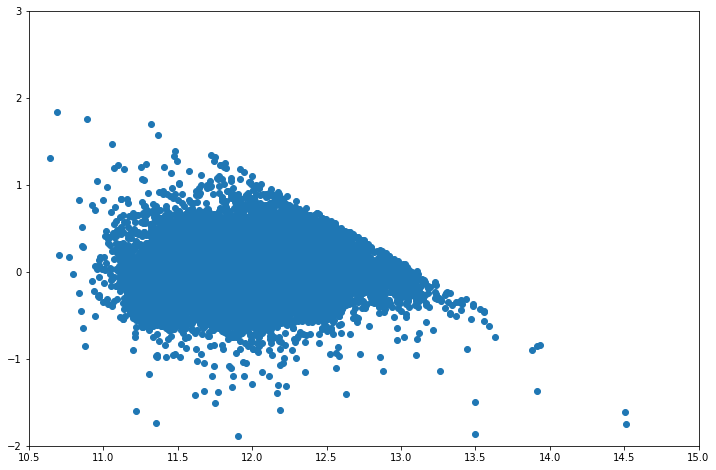

In [103]:
residual = log_housing_labels - housing_prediction

fig = plt.figure(figsize=(12,8))
plt.scatter(housing_prediction, residual)
plt.axis([10.5, 15, -2, 3])
plt.show()

In [118]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [119]:
housing_prediction = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, housing_prediction))

forest_rmse

16590.93873181356

In [121]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [122]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring = "neg_mean_squared_error", cv =10)
display_scores(forest_scores)

Scores: [-1.85103110e+09 -1.96981905e+09 -2.17237422e+09 -2.16883794e+09
 -2.00890153e+09 -2.09761352e+09 -2.05617620e+09 -2.15253843e+09
 -1.82735182e+09 -1.90366369e+09]
Mean: -2020830749.964763
Standard deviation: 123329639.00560509


## Fine Tune the Model

### Grid Search

In [123]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]} ,
    # run 12 (3x4) combinations
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
    # run 6 (2x3) combinations with bootstrap set to be False
]

forest_reg = RandomForestRegressor(random_state=16)

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=16),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [124]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=16)

In [125]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

57440.791666801284 {'max_features': 2, 'n_estimators': 3}
49980.94384941588 {'max_features': 2, 'n_estimators': 10}
47360.853107544186 {'max_features': 2, 'n_estimators': 30}
54599.03025133041 {'max_features': 4, 'n_estimators': 3}
47698.61872531755 {'max_features': 4, 'n_estimators': 10}
45458.53579958889 {'max_features': 4, 'n_estimators': 30}
53266.47553680591 {'max_features': 6, 'n_estimators': 3}
46490.5933238917 {'max_features': 6, 'n_estimators': 10}
44691.48813473363 {'max_features': 6, 'n_estimators': 30}
52631.34999050988 {'max_features': 8, 'n_estimators': 3}
46594.90986545592 {'max_features': 8, 'n_estimators': 10}
45143.26800123878 {'max_features': 8, 'n_estimators': 30}
55337.33330218345 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
49074.68591418544 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
53759.11906802598 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
47069.22089635306 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

## Evaluate the model on the Test Set

In [126]:
final_model = grid_search.best_estimator_

X_test = test_set.drop('median_house_value', axis = 1)
y_test = test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)

final_rmse = np.sqrt(final_mse)

In [127]:
final_rmse

42687.46396506982

In [128]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1,
       loc = squared_errors.mean(),
       scale=stats.sem(squared_errors)))

array([41025.97204734, 44286.66590645])

## Conclusion

Removing the capped amount for `house_median_age` and `median_house_value`, we still would come up with the same model. The models using the same algorithm. The random forest forecast model, indeed, would produce less error on the remaining dataset; however, there is no huge improvment, especially when our data is in the housing market which a change of $5,000 wouldn't really impact much.

From what we obtained, we concluded that our previous model building with the entire dataset is not heavily affected by the inconsistent data collection procedure. Our model is robust and would produce decent prediction in cases of both of removing or involving the capped amount.